In [2]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve

import tensorflow as tf
tf.random.set_seed(123)

In [4]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [8]:
print('Train size', dftrain.shape[0])
print('Test size', dfeval.shape[0])

Train size 627
Test size 264


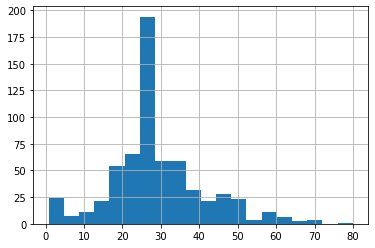

In [10]:
dftrain.age.hist(bins=20)
plt.show()

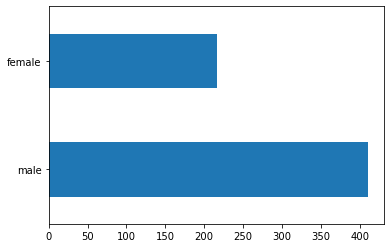

In [11]:
dftrain.sex.value_counts().plot(kind='barh')
plt.show()

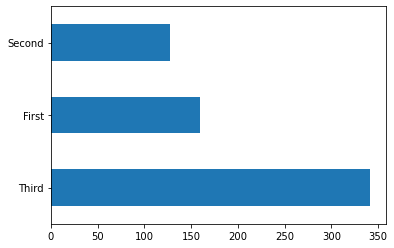

In [12]:
dftrain['class'].value_counts().plot(kind='barh')
plt.show()

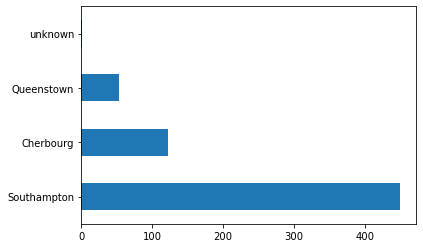

In [13]:
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

In [14]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [15]:
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

In [16]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [17]:
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [18]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
One-hot encoded:  [[0. 0. 1.]]


In [19]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [20]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [21]:
train_input_fn

<function __main__.make_input_fn.<locals>.input_fn()>

In [22]:
eval_input_fn

<function __main__.make_input_fn.<locals>.input_fn()>

In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(train_input_fn, max_steps=100)

result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [24]:
n_batches = 1
boost_tc = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

boost_tc.train(train_input_fn, max_steps=100)

result = boost_tc.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.829545
accuracy_baseline         0.625000
auc                       0.872788
auc_precision_recall      0.857807
average_loss              0.411839
label/mean                0.375000
loss                      0.411839
precision                 0.793478
prediction/mean           0.381942
recall                    0.737374
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\SANDH_~1\AppData\Local\Temp\tmp561t02jc\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


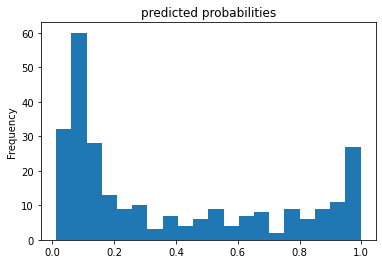

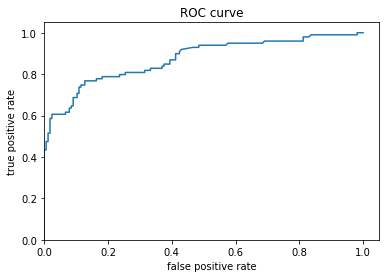

In [27]:
pred_dicts = list(boost_tc.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [49]:
custom_data = pd.DataFrame({'sex': ['male'], 'age': [15], 'n_siblings_spouses': [1], 'parch': [0], 
              'fare': [7.25], 'class': ['Second'], 'deck': ['A'], 'embark_town': ['Southampton'], 'alone': ['n']})
custom_data

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,15,1,0,7.25,Second,A,Southampton,n


In [69]:
test_fn = make_input_fn(custom_data, 1, shuffle=False, n_epochs=0)
test_fn

<function __main__.make_input_fn.<locals>.input_fn()>

In [70]:
eval_input_fn

<function __main__.make_input_fn.<locals>.input_fn()>

In [72]:
boost_tc.predict(test_fn)

<generator object Estimator.predict at 0x00000270797C9A98>